# logistic pca denoise wrc

In [1]:
import warnings
warnings.simplefilter('ignore')

import functions as ff
import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed(1) #to fix the results
rs = 3
 
#file_path = 'outputfile.txt'
#sys.stdout = open(file_path, "w")

#we define this ourselves to correct the division by zero error
def single_autocorr(series, lag):
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

In [2]:
#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open


#buld window features:
for n in list(range(1,10)):  #use 5 instead of 21 because it takes a long time
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open
    

#new window features
df['autocorr1']=df['ret1'].rolling(50).apply(lambda s:single_autocorr(s, lag=1)).fillna(0)
lg=3
df['vratio']=df['ret1'].rolling(100*lg).apply(lambda s: ff.vratio(np.log(s.values), lag=lg, cor='hom')[0]).fillna(0)

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open

#df = np.log(df+1)

#transform the target
df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
import detrendPrice 
import WhiteRealityCheckFor1 

def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    print(phi_k_p_val)
    return phi_k_corr

class CustomPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components)
        
    def fit(self, X, y=None):
        self.pca.fit(X, y)
        return self
    
    def transform(self, X):
        return self.pca.inverse_transform(self.pca.fit_transform(X))


#myscorer = None #use default accuracy score
myscorer = make_scorer(phi_k, greater_is_better=True)


# INSTRUCTIONS
Normally, PCA() in the pipeline will do feature extraction (with fit_transform(X)).  
To make PCA()in the pipeline to do feature reconstruction, requires a CustomPCA()  
(with inverse_transform(self.pca.fit_transform(X))).  
Please have a look at the CustomPCA() function.  
Below, if FeatureExtraction is set to True, PCA() will do feature extraction.  
If FeatureExtraction is set to False, CustomPCA() will do feature reconstruction.  
Open logistic_pca_denoise_WRC_results_incomplete.txt  
Note that we already ran this script with FeatureExtraction set to True.  
Run this script with FeatureExtraction set to False and   
record the missing out-of-sample result.  
Read and understand the comment.  

In [4]:
FeatureExtraction=False
if FeatureExtraction==True: ##FeatureExtraction (and Denoising) --> uncorrelated predictors
    numeric_sub_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler()),
        ('pca',  PCA())])
else: #FeatureReconstruction (Denoising only)
        numeric_sub_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler()),
        ('pca',  CustomPCA())])

    
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

#Note: transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')


logistic = LogisticRegression(max_iter=1000, solver='liblinear') 


pipe = Pipeline(steps=[('preprocessor', preprocessor),('logistic', logistic)])


ncomponents_rs =   list(range(2,len(numeric_features_ix.values)))
c_rs = np.logspace(3, -4, num=20, endpoint = True)
#penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)
p_rs= ["l1", "l2"]


param_grid =  [{'preprocessor__num__pca__n_components':ncomponents_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True, random_state=rs)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_logisticreg.csv")


ret1         float64
ret2         float64
ret3         float64
ret4         float64
ret5         float64
ret6         float64
ret7         float64
ret8         float64
ret9         float64
autocorr1    float64
vratio       float64
hour           int32
day            int32
dtype: object
0.3955987653630698
9.36290188713329e-08
0.05927867659787367
1.6920292376099155e-06
0.01581904423464653
1.7871628213872448e-05
0.1615074330522046
9.344979067460457e-06
0.028884072046119202
1.3046182661957673e-06
0.003888649305041403
3.3323617552039053e-06
0.0880491486474333
7.72768877776997e-08
0.0415642581038308
4.095265382364488e-08
0.16035656464490589
8.276759277947576e-08
0.02869744893213244
5.501101574267864e-09
0.059277264873192737
0.006931152375794447
0.16021637197221061
0.00515000821968703
0.04838546355018125
2.9936835925337135e-05
0.8235591567762578
0.0002028073112664286
0.005592159833844312
0.0004333337391624337
0.1616301238312593
3.407431363466884e-05
0.2062118186442765
0.00045623921108839394
0

In-sample: CAGR=0.0159059 Sharpe ratio=0.631392 maxDD=-0.0617796 maxDDD=810 Calmar ratio=0.257462

Out-of-sample: CAGR=0.0406631 Sharpe ratio=1.24685 maxDD=-0.0357181 maxDDD=246 Calmar ratio=1.13844  phi_k_corr=0.150482 phi_k_p_val=7.814e-06  accuracy_score=0.551

Ljung-Box test p-value 3.3764775759555387e-31
average return 0.002232
[-0.00277226  0.00274753]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.05800000000000005


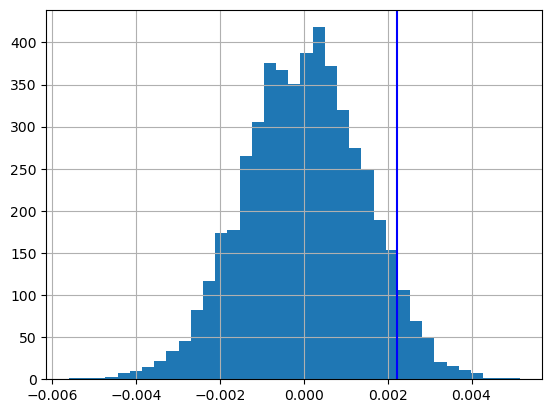

In [5]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS


dailyRet = pd.Series(positions).fillna(0).values * df_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS


dailyRet2 = pd.Series(positions2).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated LogisticRegression on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

#metrics
accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig) 
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accuracy_score))


#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
plt.close("all")

#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])

#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice.detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()





# logistic pca wrc 

In [ ]:
import warnings
warnings.simplefilter('ignore')

import functions as ff
import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed(1) #to fix the results
 
#file_path = 'outputfile.txt'
#sys.stdout = open(file_path, "w")

#we define this ourselves to correct the division by zero error
def single_autocorr(series, lag):
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open


#buld window features:
for n in list(range(1,10)):  #use 5 instead of 21 because it takes a long time
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open
   

#new window features
df['autocorr1']=df['ret1'].rolling(50).apply(lambda s:single_autocorr(s, lag=1)).fillna(0)
lg=3
df['vratio']=df['ret1'].rolling(100*lg).apply(lambda s: ff.vratio(np.log(s.values), lag=lg, cor='hom')[0]).fillna(0)

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open

#df = np.log(df+1)

#transform the target
df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import detrendPrice 
import WhiteRealityCheckFor1 

def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    print(phi_k_p_val)
    return phi_k_corr

# INSTRUCTIONS
Include a step with a feature extraction device(sklearn.decomposition.PCA)  
into the appropriate sub_pipeline, and  
in the appropriate order (before or after scaling).    
Call the step 'pca'.  
PCA is documented here:  
https://archive.is/4Cler  
Alternatively, follow the PCA example in FeatureSelectionExtractionPipelines.ipynb

In [ ]:
#myscorer = None #use default accuracy score
myscorer = make_scorer(phi_k, greater_is_better=True)

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
    ('pca', PCA())])  
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

#Note: transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')


logistic = LogisticRegression(max_iter=1000, solver='liblinear') 


pipe = Pipeline(steps=[('preprocessor', preprocessor),('logistic', logistic)])

# INSTRUCTIONS  
Specify in ncomponents_rs the number of components    
for PCA to try (from 2 to the maximum possible)  

In [ ]:
ncomponents_rs = list(range(2,len(numeric_features_ix.values)))
c_rs = np.logspace(3, -4, num=20, endpoint = True)
#penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)
p_rs= ["l1", "l2"]

# INSTRUCTIONS
The tricky part is to construct the parameter grid correctly.  
Start by proposing a key like 'preprocessor__n_components' 
(it is the wrong key but close enough)  
You will get an error.  
Following the instructions of the error message:  
Print out the list of possible keys by printing out:  
grid_search.get_params().keys()  
Find the correct key and substitute it instead of 'preprocessor__n_components'

In [ ]:
# param_grid =  [{, 'logistic__C': c_rs, 'logistic__penalty': p_rs}]
param_grid =  [{'preprocessor__num__pca__n_components':ncomponents_rs, 
                'logistic__C': c_rs, 'logistic__penalty': p_rs}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.get_params().keys()

In [ ]:
grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_logisticreg.csv")

In [ ]:
# Train set
# Make "predictions" on training set (in-sample)
#positions = np.where(best_model.predict(x_train)> 0,1,-1 )
positions = np.where(grid_search.predict(x_train)> 0,1,-1 ) #POSITIONS


dailyRet = pd.Series(positions).fillna(0).values * df_train.retFut1 #for trading right after the open

dailyRet = dailyRet.fillna(0)

cumret = np.cumprod(dailyRet + 1) - 1


plt.figure(1)
plt.plot(cumret.index, cumret)
plt.title('Cross-validated LogisticRegression on currency: train set')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TrainCumulative"))


cagr = (1 + cumret[-1]) ** (252 / len(cumret)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet) / np.std(dailyRet)
print (('In-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD))

# Test set
# Make "predictions" on test set (out-of-sample)

#positions2 = np.where(best_model.predict(x_test)> 0,1,-1 )
positions2 = np.where(grid_search.predict(x_test)> 0,1,-1 ) #POSITIONS


dailyRet2 = pd.Series(positions2).fillna(0).values * df_test.retFut1 #for trading right after the open
dailyRet2 = dailyRet2.fillna(0)

cumret2 = np.cumprod(dailyRet2 + 1) - 1

plt.figure(2)
plt.plot(cumret2.index, cumret2)
title = 'Cross-validated LogisticRegression on currency: test set'
plt.title(title)
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
#plt.show()
plt.savefig(r'Results\%s.png' %("TestCumulative"))

#metrics
accuracy_score = accuracy_score(y_test.values.ravel(), grid_search.predict(x_test))

#If this figure does not plot correctly select the lines and press F9 again
arr1 = y_test.values.ravel()
arr2 = grid_search.predict(x_test)
dfc = pd.DataFrame({'y_true': arr1, 'y_pred': arr2})
phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
significance_overview = dfc.significance_matrix(interval_cols=[])
phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
phi_k_p_val = 1 - ndtr(phi_k_sig) 
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(7, 5))
plt.tight_layout()
#plt.show()
plt.savefig(r'Results\%s.png' %("PhikSignificance"))

cagr = (1 + cumret2[-1]) ** (252 / len(cumret2)) - 1
maxDD, maxDDD = fAux.calculateMaxDD(cumret2)
ratio = (252.0 ** (1.0/2.0)) * np.mean(dailyRet2) / np.std(dailyRet2)
print (('Out-of-sample: CAGR={:0.6} Sharpe ratio={:0.6} maxDD={:0.6} maxDDD={:d} Calmar ratio={:0.6}  phi_k_corr={:0.6} phi_k_p_val={:0.6}  accuracy_score={:0.6}\n'\
).format(cagr, ratio, maxDD, maxDDD.astype(int), -cagr/maxDD, phi_k_corr, phi_k_p_val, accuracy_score))


#plot the residuals
true_y = y_test.values.ravel()
pred_y = grid_search.predict(x_test)
residuals = np.subtract(true_y, pred_y)

from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')
sns.despine()
fig.tight_layout();
#plt.show()
plt.savefig(r'Results\%s.png' %("ResidualDistribution"))
plt.close("all")

#Residual autocorrelation
#If the p-value of the test is greater than the required significance (>0.05), residuals are independent
import statsmodels.api as sm
lb = sm.stats.acorr_ljungbox(residuals, lags=[10], boxpierce=False)
print("Ljung-Box test p-value", lb.iloc[0,1])

#Detrending Prices and Returns and white reality check
detrended_open = detrendPrice.detrendPrice(openp[10000:12000])
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(positions2).fillna(0)
WhiteRealityCheckFor1.bootstrap(detrended_syst_rets)
plt.show()

column_names = []
num_numeric = best_parameters['preprocessor__num__pca__n_components']
for i in range(1,num_numeric+1):
    column_names.append('numeric_features_'+str(i))
num_dummies = len(best_model[1].coef_.ravel().tolist())-num_numeric
for i in range(1,num_dummies+1):
    column_names.append('dummies_'+str(i))

##plot the coefficients
importance = pd.DataFrame(zip(best_model[1].coef_.ravel().tolist(), column_names))
importance.columns = ['slope','feature_name']
importance_plot = sns.barplot(x=importance['feature_name'], y=importance['slope'], data=importance,orient='v',dodge=False,order=importance.sort_values('slope',ascending=False).feature_name)
for item in importance_plot.get_xticklabels(): #rotate the x labels by 90 degrees to avoid text overlapping
    item.set_rotation(90)
plt.show()
plt.savefig(r'Results\%s.png' %("Coefficients"))

# logistic svd wrc

In [ ]:
import warnings
warnings.simplefilter('ignore')

import functions as ff
import numpy as np
import pandas as pd
import fAux
import matplotlib.pyplot as plt
import seaborn as sns
import sys

np.random.seed(1) #to fix the results
 
#file_path = 'outputfile.txt'
#sys.stdout = open(file_path, "w")

#we define this ourselves to correct the division by zero error
def single_autocorr(series, lag):
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

#df = pd.read_csv('EURUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('GBPUSD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('NZDUSD_H3_200001030000_202107201800.csv', sep='\t')
df = pd.read_csv('USDCAD_H3_200001030000_202107201800.csv', sep='\t')
#df = pd.read_csv('USDCHF_H3_200001030000_202107201800.csv', sep='\t')

df['<DATETIME>'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df = df.set_index('<DATETIME>')
df.drop(['<TIME>'], axis=1, inplace=True)
df.drop(['<DATE>'], axis=1, inplace=True)

#save the open for white reality check
openp = df['<OPEN>'].copy() #for the case we want to enter trades at the open


#buld window features:
for n in list(range(1,10)):  #use 5 instead of 21 because it takes a long time
    name = 'ret' + str(n)
    df[name] = df["<OPEN>"].pct_change(periods=n) #for trading with open
    

#new window features
df['autocorr1']=df['ret1'].rolling(50).apply(lambda s:single_autocorr(s, lag=1)).fillna(0)
lg=3
df['vratio']=df['ret1'].rolling(100*lg).apply(lambda s: ff.vratio(np.log(s.values), lag=lg, cor='hom')[0]).fillna(0)

#build date-time features
df["hour"] = df.index.hour.values
df["day"] = df.index.dayofweek.values

#build target assuming we know today's open
df['retFut1'] = df['<OPEN>'].pct_change(1).shift(-1).fillna(0) #if you enter the trade immediately after the open

#df = np.log(df+1)

#transform the target
df['retFut1_categ'] = np.where((df['retFut1'] > 0), 1, 0)

#Since we are trading right after the open, 
#we only know yesterday's  high low close volume spread etc.
df['<HIGH>'] = df['<HIGH>'].shift(1)
df['<LOW>'] = df['<LOW>'].shift(1)
df['<CLOSE>'] = df['<CLOSE>'].shift(1)
df['<VOL>'] = df['<VOL>'].shift(1)
df['<SPREAD>'] = df['<SPREAD>'].shift(1)

#select the features (by dropping)
cols_to_drop = ["<OPEN>","<HIGH>","<LOW>","<CLOSE>","<TICKVOL>","<VOL>","<SPREAD>"]  #optional
df_filtered = df.drop(cols_to_drop, axis=1)

#distribute the df data into X inputs and y target
X = df_filtered.drop(['retFut1', 'retFut1_categ'], axis=1) 
y = df_filtered[['retFut1_categ']]

#select the samples
x_train = X.iloc[0:10000]
x_test = X.iloc[10000:12000]

y_train = y.iloc[0:10000]
y_test = y.iloc[10000:12000]

df_train = df_filtered.iloc[0:10000]
df_test = df_filtered.iloc[10000:12000]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer 
import phik
from phik.report import plot_correlation_matrix
from scipy.special import ndtr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
import detrendPrice 
import WhiteRealityCheckFor1 

def phi_k(y_true, y_pred):
    dfc = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    try:
        phi_k_corr = dfc.phik_matrix(interval_cols=[]).iloc[1,0]
        phi_k_sig  = dfc.significance_matrix(interval_cols=[]).iloc[1,0]
        phi_k_p_val = 1 - ndtr(phi_k_sig) 
    except:
        phi_k_corr = 0
        phi_k_p_val = 0
    print(phi_k_p_val)
    return phi_k_corr


#myscorer = None #use default accuracy score
myscorer = make_scorer(phi_k, greater_is_better=True)

numeric_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())])
categorical_sub_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
print(x_train.dtypes)
numeric_features_ix = x_train.select_dtypes(include=['float64']).columns
categorical_features_ix = x_train.select_dtypes(include=['int64']).columns

#Note: transformer 3-element tuples can be: ('name', function or pipeline, column_number_list or column_index)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_sub_pipeline, numeric_features_ix),
        ('cat', categorical_sub_pipeline, categorical_features_ix)], remainder='passthrough')


logistic = LogisticRegression(max_iter=1000, solver='liblinear') 


In [ ]:
"""
INSTRUCTIONS
Select the correct pipe with a feature extraction device(sklearn.decomposition.TruncatedSVD) 
into the regular pipeline, pipe, and do so
in the appropriate order (before or after scaling).
Call the step 'svd'.
TruncatedSVD is documented here:
https://archive.is/7LfSc
Note that we are applying TruncatedSVD to a mix of one-hot-encoded and continuous predictors.
Efficiency in handling sparse matrices makes TruncatedSVD a practical choice, but 
mixing dense and sparse predictors might reduce this advantage.
"""

pipe = Pipeline(steps=[('preprocessor', preprocessor),('svd', TruncatedSVD()),('logistic', logistic)])

ncomponents_rs =   list(range(2,x_train.shape[1]))
c_rs = np.logspace(3, -4, num=20, endpoint = True)
#penalty type=L2 like ridge regression (small coefficients preferred), L1 like lasso  (coefficients can become zero)
p_rs= ["l1", "l2"]


In [ ]:
"""
INSTRUCTIONS
Adjust param_grid to reflect the inclusion of TruncatedSVD into the pipeline pipe.
Print out the list of possible keys by printing out: grid_search.get_params().keys()
"""

param_grid =  [{'svd__n_components': ncomponents_rs, 'logistic__C': c_rs, 'logistic__penalty': p_rs}]

grid_search = RandomizedSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)
#grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring=myscorer, return_train_score=True)

grid_search.fit(x_train, y_train.values.ravel())

best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_


print("Best parameters : {}".format(best_parameters))
#print('Best estimator {}'.format(best_model))
print("Best cross-validation score : {:.2f}".format(grid_search.best_score_*100))
results = pd.DataFrame(grid_search.cv_results_)

#print(results.T)
results.to_csv("results_logisticreg.csv")

